# PM 2.5 Forecasting (Traning and Testing Version #0.1)

# DataMind Lab, Chula 2021

![](https://www.chula.ac.th/wp-content/uploads/2020/01/WEB_unicef-Chula-PM2.5-EN-scaled.jpg)

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, Input, Lambda, LeakyReLU, Conv1D, MaxPooling1D, Flatten, RepeatVector, BatchNormalization, TimeDistributed
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#from tensorflow.keras.utils.vis_utils import model_to_dot, plot_model

from datetime import date, timedelta, datetime, date
import itertools
import configparser

from scipy.special import boxcox, inv_boxcox
%matplotlib inline

In [59]:
def get_data(province) :
    
    'train section'
    train_df = pd.read_csv(f'dataset/train/{province}.csv')
    
    'test section'  
    test_df = pd.read_csv(f'dataset/test/{province}.csv')
    
    return train_df, test_df

In [60]:
train_df, test_df = get_data(province = 'Bangkok')

In [61]:
train_df

,datetime,PM2.5(µg/m3),PM10_mask,Temp(C),WindDir,Wind Speed(km/h)
0,3/3/2016 15:00,62.9,1.0,34.1,70,12
1,3/3/2016 16:00,62.9,1.0,34.6,60,12
2,3/3/2016 17:00,55.5,1.0,34.6,60,12
3,3/3/2016 18:00,55.5,1.0,34.6,60,12
4,3/3/2016 19:00,47.9,1.0,29.1,70,11
...,...,...,...,...,...,...
26643,18/3/2019 18:00,40.4,0.0,34.5,110,13
26644,18/3/2019 19:00,38.0,0.0,31.0,85,14
26645,18/3/2019 20:00,36.6,0.0,31.0,85,14
26646,18/3/2019 21:00,34.8,0.0,31.0,85,14


In [62]:
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
test_df['datetime'] = pd.to_datetime(test_df['datetime'])
train_df.set_index(train_df['datetime'],inplace=True)
test_df.set_index(test_df['datetime'],inplace=True)

In [63]:
train_df.drop(columns={'datetime'},inplace=True)
test_df.drop(columns={'datetime'},inplace=True)

In [64]:
train_df.columns

Index(['PM2.5(µg/m3)', 'PM10_mask', 'Temp(C)', 'WindDir', 'Wind Speed(km/h)'], dtype='object')

In [65]:
ft_cols = ['PM2.5(µg/m3)', 'PM10_mask', 'Temp(C)', 'WindDir', 'Wind Speed(km/h)']
train_df = train_df[ft_cols]
test_df = test_df[ft_cols]

In [66]:
train = train_df
scalers={}

for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s

test = test_df
for i in test_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

In [67]:
def split_series(series, n_past, n_future):
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      print(future_end)
    if future_end > len(series):
      break
    past, future = series[window_start:past_end], series[past_end:future_end, 0]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [68]:
X_train, y_train = split_series(train.values,24, 72)
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], X_train.shape[2])
print(X_train.shape,y_train.shape)

X_test, y_test = split_series(test.values,24, 72)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], X_test.shape[2])
print(X_test.shape,y_test.shape)

26649
(26553, 24, 5) (26553, 72)
6760
(6664, 24, 5) (6664, 72)


In [69]:
opt_params = { #optimizer params
    'lr' : 0.0001, 
    'beta_1' : 0.9,
    'beta_2' : 0.999,
}
opt = Adam(**opt_params)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [70]:
def GRU_model(n_ft = 5, n_past = 24, n_future = 72):
    
    model = Sequential()
    model.add(GRU(128,input_shape=(n_past,n_ft)))
    model.add(Dense(n_future))
    model.compile(loss = 'mse', optimizer=opt, metrics=['mae'])
    
    return model

In [71]:
gru = GRU_model(n_past=24,n_future=72)

In [72]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=1, restore_best_weights=True)
mcp_save = ModelCheckpoint('model_weights/BKK_GRU.hdf5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

In [73]:
history_gru = gru.fit(X_train, y_train, epochs=400, batch_size=128, 
                    verbose=1, validation_split=0.2,
                    callbacks=[mcp_save])

Epoch 1/400
166/166 [==============================] - 9s 7ms/step - loss: 0.0257 - mae: 0.1169 - val_loss: 0.0225 - val_mae: 0.1069

Epoch 00001: val_loss improved from inf to 0.02246, saving model to model_weights/BKK_GRU.hdf5
Epoch 2/400
166/166 [==============================] - 1s 5ms/step - loss: 0.0108 - mae: 0.0767 - val_loss: 0.0116 - val_mae: 0.0740

Epoch 00002: val_loss improved from 0.02246 to 0.01156, saving model to model_weights/BKK_GRU.hdf5
Epoch 3/400
166/166 [==============================] - 1s 5ms/step - loss: 0.0089 - mae: 0.0686 - val_loss: 0.0105 - val_mae: 0.0704

Epoch 00003: val_loss improved from 0.01156 to 0.01048, saving model to model_weights/BKK_GRU.hdf5
Epoch 4/400
166/166 [==============================] - 1s 5ms/step - loss: 0.0085 - mae: 0.0667 - val_loss: 0.0105 - val_mae: 0.0697

Epoch 00004: val_loss did not improve from 0.01048
Epoch 5/400
166/166 [==============================] - 1s 5ms/step - loss: 0.0083 - mae: 0.0660 - val_loss: 0.0098 - val

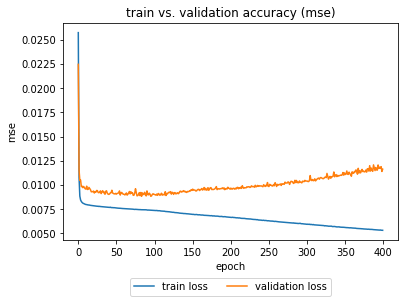

In [74]:
train_mae = history_gru.history['loss']
valid_mae = history_gru.history['val_loss']
plt.plot(train_mae, label='train loss'), 
plt.plot(valid_mae, label='validation loss')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mse)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [75]:
gru.load_weights("model_weights/BKK_GRU.hdf5")

In [76]:
pred = gru.predict(X_test)

In [79]:
X_test

array([[[0.32949513, 0.        , 0.56338028, 0.27777778, 0.21052632],
        [0.35163862, 0.        , 0.56338028, 0.27777778, 0.21052632],
        [0.34278122, 0.        , 0.56338028, 0.27777778, 0.21052632],
        ...,
        [0.27812223, 0.        , 0.60093897, 0.25      , 0.15789474],
        [0.27103632, 0.        , 0.60093897, 0.25      , 0.15789474],
        [0.27103632, 0.        , 0.57746479, 0.31944444, 0.17105263]],

       [[0.35163862, 0.        , 0.56338028, 0.27777778, 0.21052632],
        [0.34278122, 0.        , 0.56338028, 0.27777778, 0.21052632],
        [0.31178034, 0.        , 0.5399061 , 0.31944444, 0.21052632],
        ...,
        [0.27103632, 0.        , 0.60093897, 0.25      , 0.15789474],
        [0.27103632, 0.        , 0.57746479, 0.31944444, 0.17105263],
        [0.26306466, 0.        , 0.57746479, 0.31944444, 0.17105263]],

       [[0.34278122, 0.        , 0.56338028, 0.27777778, 0.21052632],
        [0.31178034, 0.        , 0.5399061 , 0.31944444, 0.2

In [82]:
scaler = scalers['scaler_PM2.5(µg/m3)']
pred=scaler.inverse_transform(pred)
y_test=scaler.inverse_transform(y_test)

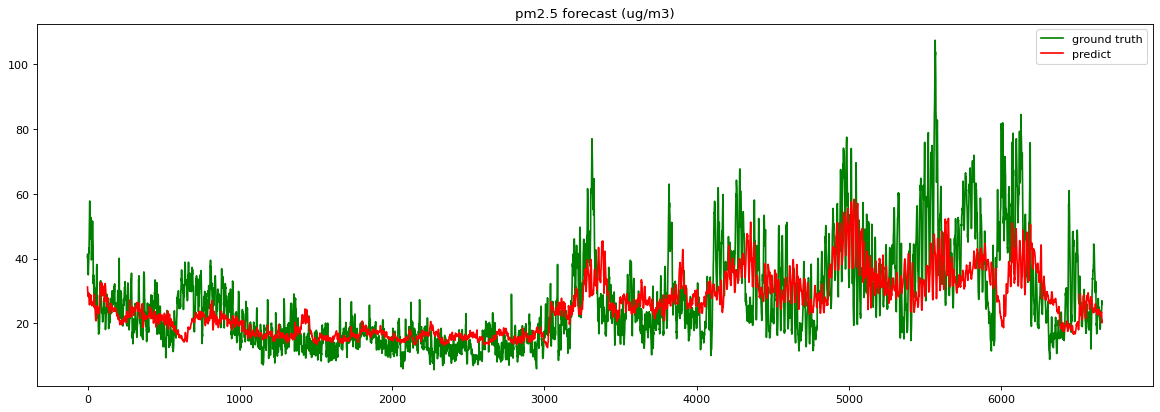

In [83]:
#visualize pred on test set +71 step
from matplotlib.pyplot import figure
figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_test[:,71],'g',label='ground truth')
plt.plot(pred[:,71],'r',label='predict')
plt.title("pm2.5 forecast (ug/m3)")
plt.legend(loc="upper right")

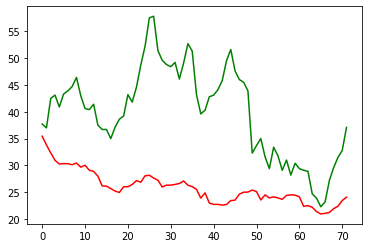

In [84]:
#visualize prediction on random batch (test set)
plt.plot(y_test[60,:],'g',label='ground truth')
plt.plot(pred[60,:],'r',label='pred')

In [85]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error , mean_absolute_error
import math
print("MAE : ",mean_absolute_error(y_test[:,:],pred[:,:]),end=", ")
print("RMSE : ",math.sqrt(mean_squared_error(y_test[:,:],pred[:,:])))

MAE :  6.822712631303588, RMSE :  9.722294014249183


In [86]:
import numpy as np
import itertools
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def single_mean_absolute_percentage_error(y_true, y_pred,i): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def evaluate_level(inv_ytest,inv_yhat,i):
  high_ytest = []
  med_ytest = []
  low_ytest = []
  high_yhat = []
  med_yhat = []
  low_yhat = []
  for index,val in enumerate(inv_ytest[:,i,0]):
    if val < 35.5:
      low_ytest.append(val)
      low_yhat.append(inv_yhat[index,i,0])     
    elif 35.5 <= val < 55.5:
      med_ytest.append(val)  
      med_yhat.append(inv_yhat[index,i,0])    
    elif val >= 55.5:
      high_ytest.append(val)
      high_yhat.append(inv_yhat[index,i,0])

  high_ytest = np.array(high_ytest)
  high_yhat = np.array(high_yhat)
  med_ytest = np.array(med_ytest)
  med_yhat = np.array(med_yhat)
  low_ytest = np.array(low_ytest)
  low_yhat = np.array(low_yhat)

  print('High level RMSE: %.3f' % math.sqrt(mean_squared_error(np.array(high_ytest), np.array(high_yhat))))
  print('High level MAE: %.3f' % mean_absolute_error(high_ytest, high_yhat))
  print('High level MAPE: %.3f' % single_mean_absolute_percentage_error(high_ytest, high_yhat,i))
  
  print('Med level RMSE: %.3f' % math.sqrt(mean_squared_error(np.array(med_ytest), np.array(med_yhat))))
  print('Med level MAE: %.3f' % mean_absolute_error(med_ytest, med_yhat))
  print('Med level MAPE: %.3f' % single_mean_absolute_percentage_error(med_ytest, med_yhat,i))
    
  print('low level RMSE: %.3f' % math.sqrt(mean_squared_error(np.array(low_ytest), np.array(low_yhat))))
  print('low level MAE: %.3f' % mean_absolute_error(low_ytest, low_yhat))
  print('low level MAPE: %.3f' % single_mean_absolute_percentage_error(low_ytest, low_yhat,i))

def generate_class(inv_ytest,inv_yhat,i):
    class_ytest = []
    class_yhat = []
    #print(inv_ytest[:,i,0])
    #print(inv_yhat[:,i,0])

    for index,val in enumerate(inv_ytest[:,i,0]):
        if val < 35.5:
            class_ytest.append(0)
        elif 35.5 <= val <= 55.5:
            class_ytest.append(1)     
        elif val > 55.5:
            class_ytest.append(2) 
    for index,val in enumerate(inv_yhat[:,i,0]):
        if val < 35.5:
            class_yhat.append(0)   
        elif 35.5 <= val <= 55.5:
            class_yhat.append(1)     
        elif val > 55.5:
            class_yhat.append(2)
    target_names = ['Low AQI','Medium AQI','High AQI']
    print('')
    cls_report = classification_report(class_ytest, class_yhat, target_names=target_names,output_dict=True)
    print(classification_report(class_ytest, class_yhat, target_names=target_names))
    conf = confusion_matrix(class_ytest, class_yhat)
    plt.figure()
    plot_confusion_matrix(conf,classes=['Low AQI','Med AQI','High AQI'])
    plt.show()
    return cls_report
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    



              precision    recall  f1-score   support

     Low AQI       0.98      0.98      0.98      5159
  Medium AQI       0.85      0.86      0.85      1129
    High AQI       0.91      0.83      0.87       376

    accuracy                           0.95      6664
   macro avg       0.91      0.89      0.90      6664
weighted avg       0.95      0.95      0.95      6664




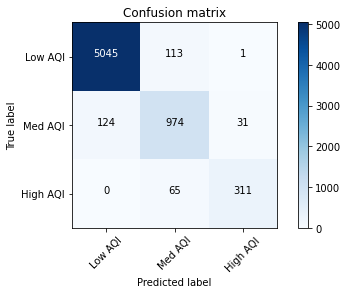

Day  0 :
MAE :  2.1649441244793968, RMSE :  2.961991193229078
High level RMSE: 5.387
High level MAE: 4.288
High level MAPE: 6.478
Med level RMSE: 3.700
Med level MAE: 2.879
Med level MAPE: 6.623
low level RMSE: 2.491
low level MAE: 1.853
low level MAPE: 9.844

              precision    recall  f1-score   support

     Low AQI       0.98      0.98      0.98      5159
  Medium AQI       0.85      0.86      0.85      1129
    High AQI       0.91      0.83      0.87       376

    accuracy                           0.95      6664
   macro avg       0.91      0.89      0.90      6664
weighted avg       0.95      0.95      0.95      6664




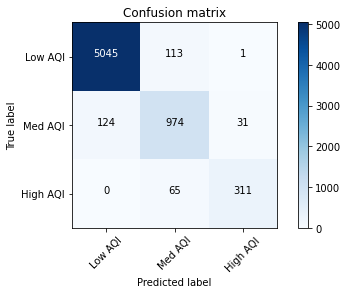

Day  1 :
MAE :  3.4221766931240727, RMSE :  4.652316745593517
High level RMSE: 8.957
High level MAE: 7.257
High level MAPE: 10.903
Med level RMSE: 5.699
Med level MAE: 4.522
Med level MAPE: 10.377
low level RMSE: 3.867
low level MAE: 2.899
low level MAPE: 15.189

              precision    recall  f1-score   support

     Low AQI       0.97      0.96      0.96      5159
  Medium AQI       0.72      0.81      0.77      1129
    High AQI       0.87      0.66      0.75       376

    accuracy                           0.92      6664
   macro avg       0.85      0.81      0.83      6664
weighted avg       0.92      0.92      0.92      6664




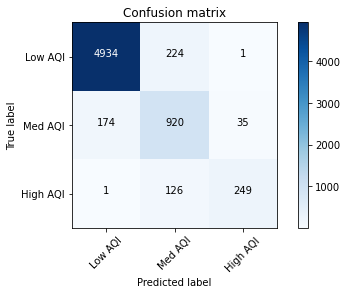

Day  2 :
MAE :  4.395963316976952, RMSE :  5.9848564462620075
High level RMSE: 11.229
High level MAE: 9.164
High level MAPE: 13.746
Med level RMSE: 7.121
Med level MAE: 5.664
Med level MAPE: 13.024
low level RMSE: 5.090
low level MAE: 3.768
low level MAPE: 19.484

              precision    recall  f1-score   support

     Low AQI       0.96      0.93      0.95      5159
  Medium AQI       0.63      0.75      0.68      1129
    High AQI       0.75      0.57      0.65       376

    accuracy                           0.88      6664
   macro avg       0.78      0.75      0.76      6664
weighted avg       0.89      0.88      0.88      6664




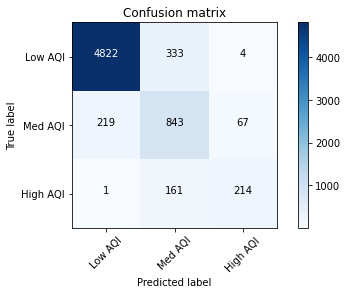

Day  3 :
MAE :  5.057976509457162, RMSE :  6.914936993604769
High level RMSE: 13.587
High level MAE: 11.371
High level MAPE: 17.077
Med level RMSE: 7.972
Med level MAE: 6.314
Med level MAPE: 14.494
low level RMSE: 5.855
low level MAE: 4.318
low level MAPE: 22.376

              precision    recall  f1-score   support

     Low AQI       0.95      0.92      0.94      5159
  Medium AQI       0.58      0.71      0.64      1129
    High AQI       0.70      0.45      0.55       376

    accuracy                           0.86      6664
   macro avg       0.74      0.70      0.71      6664
weighted avg       0.87      0.86      0.86      6664




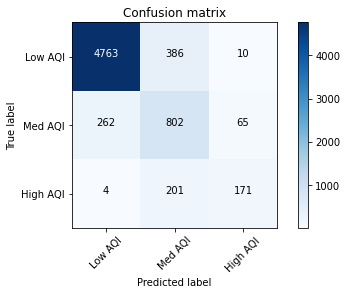

Day  4 :
MAE :  5.41411003070433, RMSE :  7.429300290185829
High level RMSE: 14.874
High level MAE: 12.578
High level MAPE: 18.919
Med level RMSE: 8.477
Med level MAE: 6.762
Med level MAPE: 15.501
low level RMSE: 6.269
low level MAE: 4.591
low level MAPE: 23.756

              precision    recall  f1-score   support

     Low AQI       0.94      0.92      0.93      5159
  Medium AQI       0.55      0.69      0.61      1129
    High AQI       0.67      0.40      0.50       376

    accuracy                           0.85      6664
   macro avg       0.72      0.67      0.68      6664
weighted avg       0.86      0.85      0.85      6664




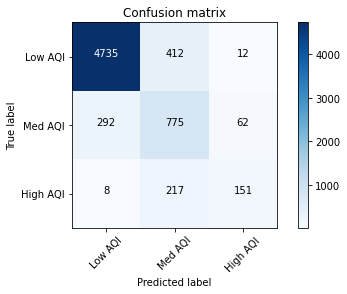


              precision    recall  f1-score   support

     Low AQI       0.93      0.92      0.93      5159
  Medium AQI       0.53      0.67      0.59      1129
    High AQI       0.66      0.32      0.43       376

    accuracy                           0.84      6664
   macro avg       0.71      0.64      0.65      6664
weighted avg       0.85      0.84      0.84      6664




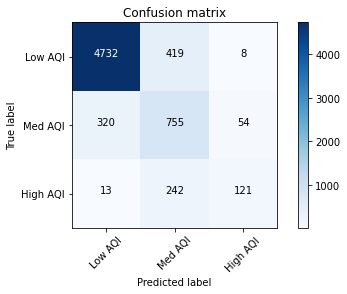

Day  5 :
MAE :  5.650468197074972, RMSE :  7.798640096918132
High level RMSE: 16.404
High level MAE: 14.031
High level MAPE: 21.092
Med level RMSE: 8.855
Med level MAE: 7.081
Med level MAPE: 16.201
low level RMSE: 6.450
low level MAE: 4.720
low level MAPE: 24.351

              precision    recall  f1-score   support

     Low AQI       0.93      0.92      0.93      5159
  Medium AQI       0.53      0.67      0.59      1129
    High AQI       0.66      0.32      0.43       376

    accuracy                           0.84      6664
   macro avg       0.71      0.64      0.65      6664
weighted avg       0.85      0.84      0.84      6664




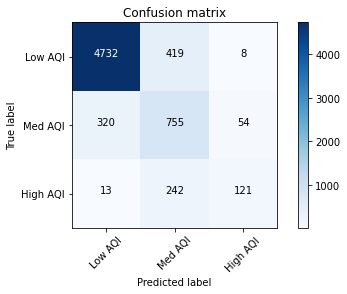

Day  6 :
MAE :  5.812817968812738, RMSE :  7.974992289113762
High level RMSE: 16.987
High level MAE: 14.706
High level MAPE: 22.138
Med level RMSE: 8.964
Med level MAE: 7.228
Med level MAPE: 16.525
low level RMSE: 6.583
low level MAE: 4.848
low level MAPE: 25.320

              precision    recall  f1-score   support

     Low AQI       0.93      0.91      0.92      5159
  Medium AQI       0.52      0.66      0.58      1129
    High AQI       0.66      0.30      0.41       376

    accuracy                           0.84      6664
   macro avg       0.70      0.62      0.64      6664
weighted avg       0.85      0.84      0.84      6664




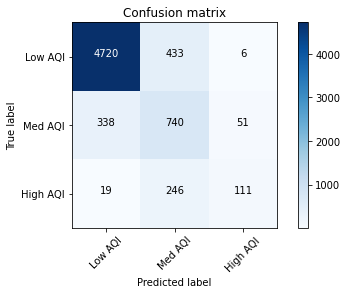

Day  7 :
MAE :  5.898929618157688, RMSE :  8.201664056638762
High level RMSE: 18.321
High level MAE: 15.855
High level MAPE: 23.869
Med level RMSE: 9.608
Med level MAE: 7.790
Med level MAPE: 17.771
low level RMSE: 6.481
low level MAE: 4.752
low level MAPE: 24.854

              precision    recall  f1-score   support

     Low AQI       0.92      0.92      0.92      5160
  Medium AQI       0.50      0.60      0.55      1128
    High AQI       0.55      0.21      0.30       376

    accuracy                           0.82      6664
   macro avg       0.65      0.58      0.59      6664
weighted avg       0.83      0.82      0.82      6664




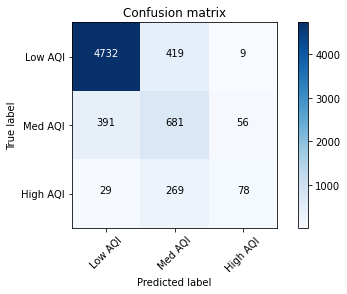

Day  8 :
MAE :  5.92000179061798, RMSE :  8.225664479968673
High level RMSE: 18.928
High level MAE: 16.623
High level MAPE: 24.977
Med level RMSE: 9.378
Med level MAE: 7.563
Med level MAPE: 17.226
low level RMSE: 6.465
low level MAE: 4.773
low level MAPE: 25.088

              precision    recall  f1-score   support

     Low AQI       0.92      0.92      0.92      5161
  Medium AQI       0.50      0.64      0.56      1127
    High AQI       0.57      0.16      0.25       376

    accuracy                           0.83      6664
   macro avg       0.66      0.57      0.57      6664
weighted avg       0.83      0.83      0.82      6664




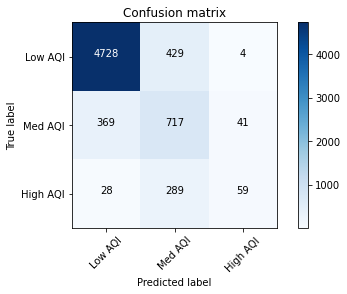

Day  9 :
MAE :  5.998413584011944, RMSE :  8.391411243290108
High level RMSE: 19.714
High level MAE: 17.291
High level MAPE: 25.994
Med level RMSE: 9.674
Med level MAE: 7.860
Med level MAPE: 17.875
low level RMSE: 6.473
low level MAE: 4.761
low level MAPE: 25.098

              precision    recall  f1-score   support

     Low AQI       0.92      0.92      0.92      5162
  Medium AQI       0.49      0.61      0.54      1126
    High AQI       0.52      0.14      0.22       376

    accuracy                           0.82      6664
   macro avg       0.64      0.55      0.56      6664
weighted avg       0.82      0.82      0.81      6664




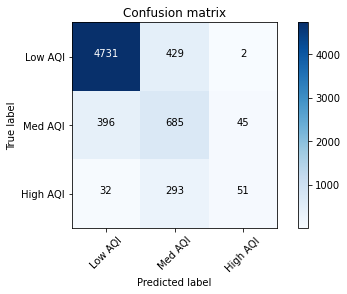

Day  10 :
MAE :  6.00430090670683, RMSE :  8.460574276137427
High level RMSE: 20.038
High level MAE: 17.308
High level MAPE: 25.993
Med level RMSE: 9.938
Med level MAE: 8.017
Med level MAPE: 18.191
low level RMSE: 6.429
low level MAE: 4.733
low level MAPE: 25.117

              precision    recall  f1-score   support

     Low AQI       0.91      0.92      0.92      5163
  Medium AQI       0.50      0.60      0.54      1125
    High AQI       0.56      0.18      0.27       376

    accuracy                           0.82      6664
   macro avg       0.66      0.56      0.58      6664
weighted avg       0.82      0.82      0.82      6664




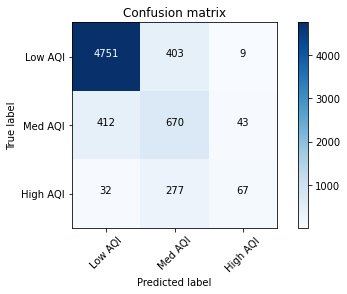


              precision    recall  f1-score   support

     Low AQI       0.91      0.92      0.92      5163
  Medium AQI       0.49      0.59      0.54      1125
    High AQI       0.52      0.13      0.20       376

    accuracy                           0.82      6664
   macro avg       0.64      0.55      0.55      6664
weighted avg       0.82      0.82      0.81      6664




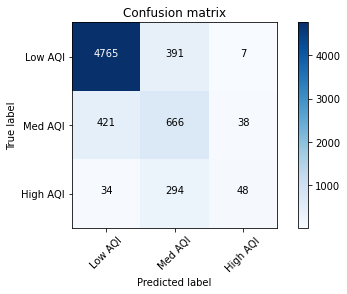

Day  11 :
MAE :  6.029166372369032, RMSE :  8.52418426661407
High level RMSE: 20.875
High level MAE: 18.311
High level MAPE: 27.496
Med level RMSE: 9.988
Med level MAE: 8.096
Med level MAPE: 18.313
low level RMSE: 6.324
low level MAE: 4.674
low level MAPE: 24.975

              precision    recall  f1-score   support

     Low AQI       0.91      0.92      0.92      5163
  Medium AQI       0.49      0.59      0.54      1125
    High AQI       0.52      0.13      0.20       376

    accuracy                           0.82      6664
   macro avg       0.64      0.55      0.55      6664
weighted avg       0.82      0.82      0.81      6664




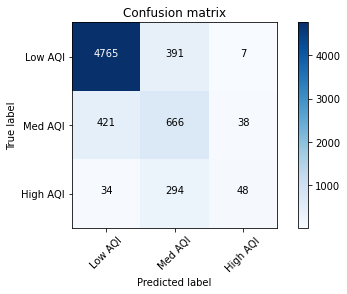

Day  12 :
MAE :  6.084629864509509, RMSE :  8.583902343302324
High level RMSE: 21.322
High level MAE: 18.710
High level MAPE: 28.077
Med level RMSE: 9.868
Med level MAE: 7.984
Med level MAPE: 18.035
low level RMSE: 6.358
low level MAE: 4.740
low level MAPE: 25.508

              precision    recall  f1-score   support

     Low AQI       0.92      0.92      0.92      5162
  Medium AQI       0.50      0.60      0.55      1126
    High AQI       0.50      0.12      0.20       376

    accuracy                           0.82      6664
   macro avg       0.64      0.55      0.55      6664
weighted avg       0.82      0.82      0.82      6664




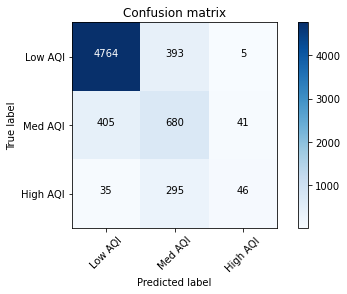

Day  13 :
MAE :  6.157948159141129, RMSE :  8.653426412548384
High level RMSE: 21.469
High level MAE: 19.014
High level MAPE: 28.573
Med level RMSE: 9.937
Med level MAE: 8.031
Med level MAPE: 18.141
low level RMSE: 6.418
low level MAE: 4.802
low level MAPE: 26.053

              precision    recall  f1-score   support

     Low AQI       0.91      0.92      0.92      5161
  Medium AQI       0.50      0.61      0.55      1127
    High AQI       0.49      0.10      0.17       376

    accuracy                           0.82      6664
   macro avg       0.63      0.54      0.54      6664
weighted avg       0.82      0.82      0.81      6664




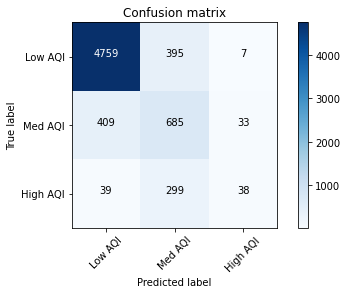

Day  14 :
MAE :  6.104598778178569, RMSE :  8.628638499098097
High level RMSE: 21.397
High level MAE: 18.947
High level MAPE: 28.491
Med level RMSE: 9.973
Med level MAE: 8.064
Med level MAPE: 18.268
low level RMSE: 6.380
low level MAE: 4.730
low level MAPE: 25.376

              precision    recall  f1-score   support

     Low AQI       0.91      0.92      0.92      5160
  Medium AQI       0.50      0.61      0.55      1128
    High AQI       0.50      0.11      0.18       376

    accuracy                           0.82      6664
   macro avg       0.64      0.55      0.55      6664
weighted avg       0.82      0.82      0.81      6664




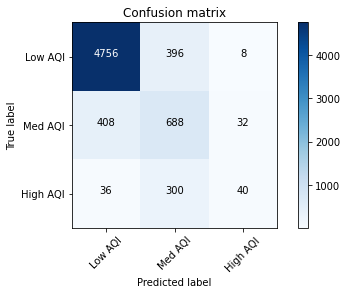

Day  15 :
MAE :  6.093154927376224, RMSE :  8.644442052628284
High level RMSE: 22.074
High level MAE: 19.656
High level MAPE: 29.563
Med level RMSE: 10.093
Med level MAE: 8.165
Med level MAPE: 18.447
low level RMSE: 6.192
low level MAE: 4.640
low level MAPE: 25.020

              precision    recall  f1-score   support

     Low AQI       0.91      0.93      0.92      5159
  Medium AQI       0.50      0.60      0.55      1129
    High AQI       0.51      0.09      0.15       376

    accuracy                           0.83      6664
   macro avg       0.64      0.54      0.54      6664
weighted avg       0.82      0.83      0.81      6664




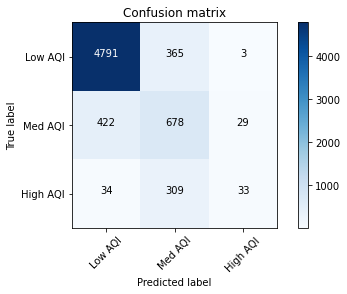

Day  16 :
MAE :  6.100371789760522, RMSE :  8.603637773367733
High level RMSE: 20.828
High level MAE: 18.361
High level MAPE: 27.616
Med level RMSE: 10.025
Med level MAE: 8.040
Med level MAPE: 18.278
low level RMSE: 6.455
low level MAE: 4.772
low level MAPE: 25.642

              precision    recall  f1-score   support

     Low AQI       0.92      0.93      0.92      5158
  Medium AQI       0.51      0.61      0.55      1130
    High AQI       0.53      0.14      0.22       376

    accuracy                           0.83      6664
   macro avg       0.65      0.56      0.56      6664
weighted avg       0.83      0.83      0.82      6664




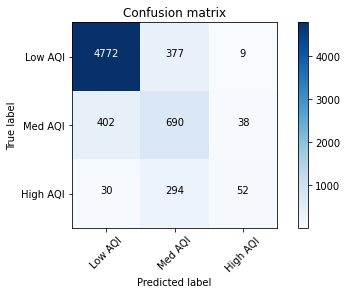

Day  17 :
MAE :  6.114359976120499, RMSE :  8.683129986301063
High level RMSE: 22.347
High level MAE: 20.123
High level MAPE: 30.285
Med level RMSE: 10.140
Med level MAE: 8.210
Med level MAPE: 18.556
low level RMSE: 6.171
low level MAE: 4.622
low level MAPE: 24.939

              precision    recall  f1-score   support

     Low AQI       0.91      0.93      0.92      5157
  Medium AQI       0.51      0.62      0.56      1131
    High AQI       0.62      0.06      0.10       376

    accuracy                           0.83      6664
   macro avg       0.68      0.54      0.53      6664
weighted avg       0.83      0.83      0.82      6664




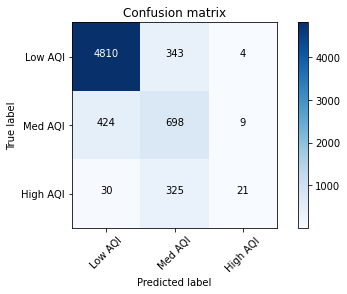

Day  18 :
MAE :  6.035738169359846, RMSE :  8.588946943318703
High level RMSE: 21.475
High level MAE: 18.915
High level MAPE: 28.448
Med level RMSE: 10.295
Med level MAE: 8.275
Med level MAPE: 18.763
low level RMSE: 6.172
low level MAE: 4.595
low level MAPE: 24.892

              precision    recall  f1-score   support

     Low AQI       0.91      0.93      0.92      5156
  Medium AQI       0.51      0.59      0.54      1132
    High AQI       0.50      0.10      0.17       376

    accuracy                           0.83      6664
   macro avg       0.64      0.54      0.55      6664
weighted avg       0.82      0.83      0.82      6664




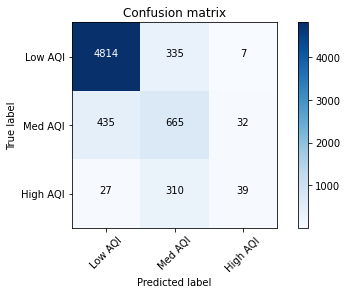

Day  19 :
MAE :  6.0563049804978295, RMSE :  8.553582648734377
High level RMSE: 20.947
High level MAE: 18.408
High level MAPE: 27.642
Med level RMSE: 9.896
Med level MAE: 7.879
Med level MAPE: 17.888
low level RMSE: 6.381
low level MAE: 4.745
low level MAPE: 25.644

              precision    recall  f1-score   support

     Low AQI       0.92      0.92      0.92      5155
  Medium AQI       0.51      0.63      0.56      1133
    High AQI       0.49      0.10      0.16       376

    accuracy                           0.83      6664
   macro avg       0.64      0.55      0.55      6664
weighted avg       0.83      0.83      0.82      6664




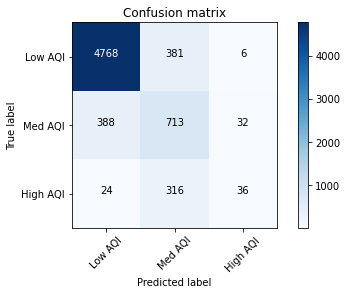

Day  20 :
MAE :  6.0659717738986165, RMSE :  8.59041234042587
High level RMSE: 21.185
High level MAE: 18.387
High level MAPE: 27.624
Med level RMSE: 10.214
Med level MAE: 8.197
Med level MAPE: 18.581
low level RMSE: 6.276
low level MAE: 4.688
low level MAPE: 25.387

              precision    recall  f1-score   support

     Low AQI       0.92      0.93      0.92      5154
  Medium AQI       0.51      0.60      0.55      1134
    High AQI       0.55      0.14      0.22       376

    accuracy                           0.83      6664
   macro avg       0.66      0.55      0.56      6664
weighted avg       0.83      0.83      0.82      6664




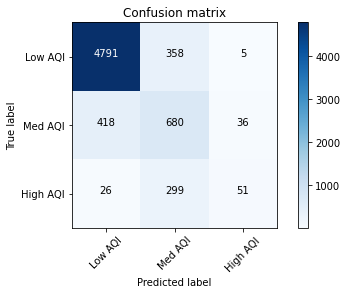

Day  21 :
MAE :  6.090390506769572, RMSE :  8.692798829725659
High level RMSE: 21.359
High level MAE: 18.402
High level MAPE: 27.687
Med level RMSE: 10.608
Med level MAE: 8.608
Med level MAPE: 19.523
low level RMSE: 6.270
low level MAE: 4.628
low level MAPE: 24.891

              precision    recall  f1-score   support

     Low AQI       0.91      0.94      0.92      5153
  Medium AQI       0.52      0.56      0.54      1135
    High AQI       0.57      0.15      0.24       376

    accuracy                           0.83      6664
   macro avg       0.67      0.55      0.57      6664
weighted avg       0.82      0.83      0.82      6664




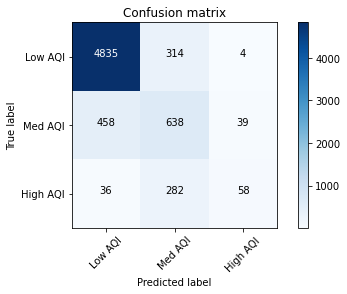

Day  22 :
MAE :  6.130652561708659, RMSE :  8.721287713624642
High level RMSE: 21.346
High level MAE: 18.518
High level MAPE: 27.865
Med level RMSE: 10.462
Med level MAE: 8.441
Med level MAPE: 19.139
low level RMSE: 6.376
low level MAE: 4.707
low level MAPE: 25.193

              precision    recall  f1-score   support

     Low AQI       0.91      0.94      0.92      5152
  Medium AQI       0.51      0.57      0.54      1136
    High AQI       0.58      0.14      0.23       376

    accuracy                           0.83      6664
   macro avg       0.67      0.55      0.56      6664
weighted avg       0.82      0.83      0.82      6664




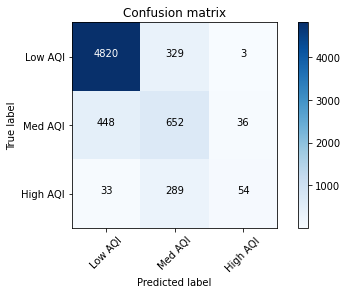


              precision    recall  f1-score   support

     Low AQI       0.91      0.93      0.92      5151
  Medium AQI       0.50      0.57      0.53      1137
    High AQI       0.59      0.14      0.22       376

    accuracy                           0.83      6664
   macro avg       0.67      0.55      0.56      6664
weighted avg       0.82      0.83      0.81      6664




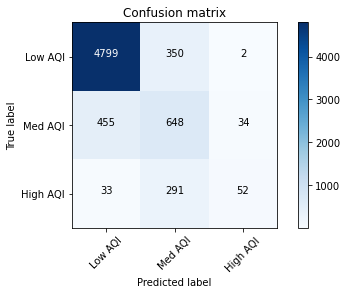

Day  23 :
MAE :  6.229430263526156, RMSE :  8.82495740692821
High level RMSE: 21.528
High level MAE: 18.762
High level MAPE: 28.227
Med level RMSE: 10.488
Med level MAE: 8.513
Med level MAPE: 19.303
low level RMSE: 6.504
low level MAE: 4.801
low level MAPE: 25.574

              precision    recall  f1-score   support

     Low AQI       0.91      0.93      0.92      5151
  Medium AQI       0.50      0.57      0.53      1137
    High AQI       0.59      0.14      0.22       376

    accuracy                           0.83      6664
   macro avg       0.67      0.55      0.56      6664
weighted avg       0.82      0.83      0.81      6664




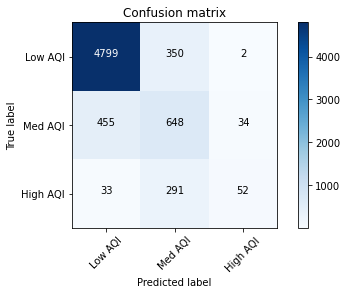

Day  24 :
MAE :  6.379176798530844, RMSE :  8.962737840964902
High level RMSE: 21.470
High level MAE: 18.788
High level MAPE: 28.269
Med level RMSE: 10.522
Med level MAE: 8.569
Med level MAPE: 19.417
low level RMSE: 6.746
low level MAE: 4.980
low level MAPE: 26.860

              precision    recall  f1-score   support

     Low AQI       0.91      0.93      0.92      5151
  Medium AQI       0.50      0.56      0.53      1137
    High AQI       0.56      0.13      0.22       376

    accuracy                           0.82      6664
   macro avg       0.65      0.54      0.55      6664
weighted avg       0.82      0.82      0.81      6664




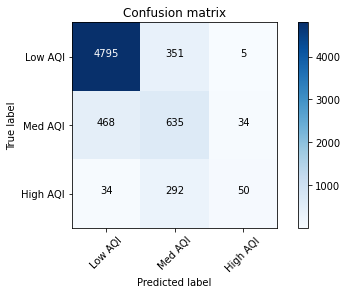

Day  25 :
MAE :  6.550572061424209, RMSE :  9.124960869699894
High level RMSE: 21.725
High level MAE: 19.117
High level MAPE: 28.736
Med level RMSE: 10.332
Med level MAE: 8.356
Med level MAPE: 18.907
low level RMSE: 7.025
low level MAE: 5.224
low level MAPE: 28.249

              precision    recall  f1-score   support

     Low AQI       0.91      0.92      0.91      5151
  Medium AQI       0.48      0.58      0.52      1137
    High AQI       0.58      0.12      0.21       376

    accuracy                           0.82      6664
   macro avg       0.66      0.54      0.55      6664
weighted avg       0.82      0.82      0.81      6664




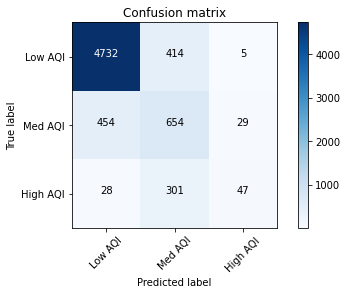

Day  26 :
MAE :  6.682084563886131, RMSE :  9.292385505998707
High level RMSE: 22.132
High level MAE: 19.671
High level MAPE: 29.576
Med level RMSE: 10.566
Med level MAE: 8.539
Med level MAPE: 19.297
low level RMSE: 7.138
low level MAE: 5.313
low level MAPE: 28.623

              precision    recall  f1-score   support

     Low AQI       0.90      0.92      0.91      5151
  Medium AQI       0.47      0.56      0.51      1137
    High AQI       0.52      0.08      0.14       376

    accuracy                           0.81      6664
   macro avg       0.63      0.52      0.52      6664
weighted avg       0.81      0.81      0.80      6664




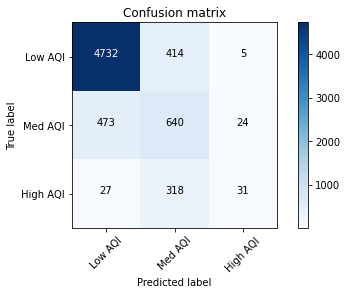

Day  27 :
MAE :  6.832710097216759, RMSE :  9.545034793867705
High level RMSE: 23.393
High level MAE: 20.967
High level MAPE: 31.564
Med level RMSE: 10.991
Med level MAE: 9.027
Med level MAPE: 20.337
low level RMSE: 7.131
low level MAE: 5.305
low level MAPE: 28.758

              precision    recall  f1-score   support

     Low AQI       0.89      0.92      0.91      5151
  Medium AQI       0.46      0.51      0.48      1137
    High AQI       0.55      0.09      0.15       376

    accuracy                           0.81      6664
   macro avg       0.63      0.51      0.51      6664
weighted avg       0.80      0.81      0.79      6664




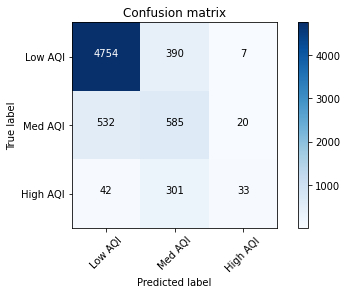

Day  28 :
MAE :  6.961701010799064, RMSE :  9.755583611417205
High level RMSE: 23.614
High level MAE: 21.194
High level MAPE: 31.927
Med level RMSE: 11.260
Med level MAE: 9.206
Med level MAPE: 20.777
low level RMSE: 7.350
low level MAE: 5.416
low level MAPE: 28.947

              precision    recall  f1-score   support

     Low AQI       0.89      0.92      0.90      5151
  Medium AQI       0.45      0.52      0.48      1137
    High AQI       0.44      0.07      0.12       376

    accuracy                           0.80      6664
   macro avg       0.59      0.50      0.50      6664
weighted avg       0.79      0.80      0.79      6664




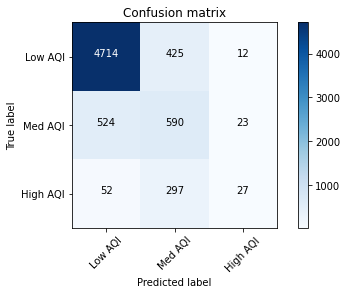

Day  29 :
MAE :  7.012406326542381, RMSE :  9.818992936545367
High level RMSE: 24.603
High level MAE: 22.403
High level MAPE: 33.802
Med level RMSE: 11.472
Med level MAE: 9.559
Med level MAPE: 21.515
low level RMSE: 7.144
low level MAE: 5.314
low level MAPE: 28.727

              precision    recall  f1-score   support

     Low AQI       0.88      0.92      0.90      5151
  Medium AQI       0.44      0.48      0.46      1137
    High AQI       0.54      0.05      0.09       376

    accuracy                           0.80      6664
   macro avg       0.62      0.48      0.48      6664
weighted avg       0.79      0.80      0.78      6664




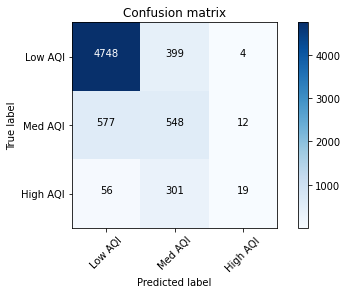

Day  30 :
MAE :  7.121246528482381, RMSE :  9.973980358850394
High level RMSE: 25.112
High level MAE: 22.906
High level MAPE: 34.586
Med level RMSE: 11.608
Med level MAE: 9.644
Med level MAPE: 21.721
low level RMSE: 7.242
low level MAE: 5.399
low level MAPE: 29.324

              precision    recall  f1-score   support

     Low AQI       0.88      0.92      0.90      5151
  Medium AQI       0.45      0.49      0.47      1137
    High AQI       0.60      0.05      0.09       376

    accuracy                           0.80      6664
   macro avg       0.64      0.49      0.49      6664
weighted avg       0.79      0.80      0.78      6664




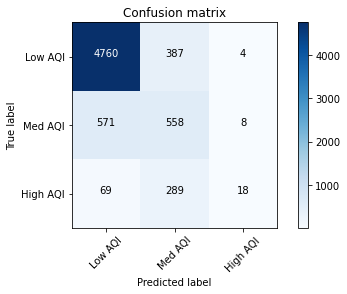

Day  31 :
MAE :  7.131084913537711, RMSE :  10.03105026052491
High level RMSE: 26.067
High level MAE: 24.003
High level MAPE: 36.289
Med level RMSE: 12.037
Med level MAE: 10.148
Med level MAPE: 22.819
low level RMSE: 6.934
low level MAE: 5.220
low level MAPE: 28.413

              precision    recall  f1-score   support

     Low AQI       0.87      0.93      0.90      5151
  Medium AQI       0.45      0.44      0.44      1137
    High AQI       0.52      0.04      0.07       376

    accuracy                           0.80      6664
   macro avg       0.61      0.47      0.47      6664
weighted avg       0.78      0.80      0.78      6664




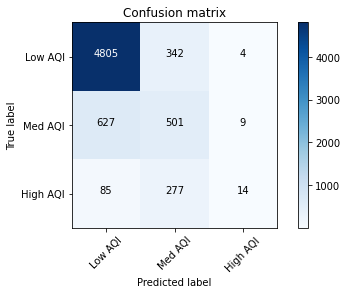

Day  32 :
MAE :  7.1308776819691655, RMSE :  9.996680760275463
High level RMSE: 25.496
High level MAE: 23.377
High level MAPE: 35.311
Med level RMSE: 11.628
Med level MAE: 9.688
Med level MAPE: 21.827
low level RMSE: 7.176
low level MAE: 5.367
low level MAPE: 28.975

              precision    recall  f1-score   support

     Low AQI       0.88      0.92      0.90      5151
  Medium AQI       0.45      0.48      0.47      1137
    High AQI       0.59      0.06      0.11       376

    accuracy                           0.80      6664
   macro avg       0.64      0.49      0.49      6664
weighted avg       0.79      0.80      0.78      6664




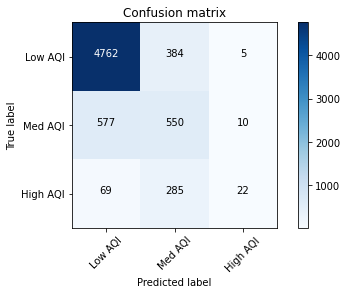

Day  33 :
MAE :  7.140228049923965, RMSE :  10.091962662341905
High level RMSE: 26.006
High level MAE: 23.821
High level MAPE: 35.999
Med level RMSE: 12.101
Med level MAE: 10.162
Med level MAPE: 22.896
low level RMSE: 7.040
low level MAE: 5.242
low level MAPE: 28.224

              precision    recall  f1-score   support

     Low AQI       0.87      0.93      0.90      5151
  Medium AQI       0.44      0.43      0.44      1137
    High AQI       0.49      0.07      0.13       376

    accuracy                           0.80      6664
   macro avg       0.60      0.48      0.49      6664
weighted avg       0.78      0.80      0.78      6664




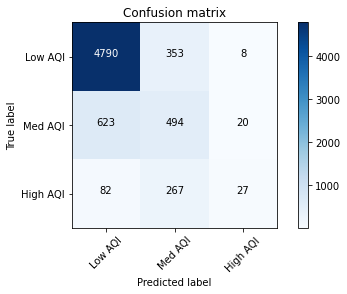

Day  34 :
MAE :  7.1987074792170445, RMSE :  10.127488694256357
High level RMSE: 26.489
High level MAE: 24.420
High level MAPE: 36.893
Med level RMSE: 11.936
Med level MAE: 10.031
Med level MAPE: 22.519
low level RMSE: 7.036
low level MAE: 5.303
low level MAPE: 29.065

              precision    recall  f1-score   support

     Low AQI       0.88      0.93      0.90      5152
  Medium AQI       0.45      0.46      0.46      1136
    High AQI       0.63      0.06      0.12       376

    accuracy                           0.80      6664
   macro avg       0.65      0.49      0.49      6664
weighted avg       0.79      0.80      0.78      6664




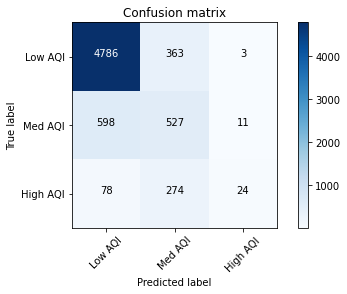

Day  35 :
MAE :  7.174993596958513, RMSE :  10.154205594109971
High level RMSE: 27.010
High level MAE: 24.965
High level MAPE: 37.709
Med level RMSE: 12.161
Med level MAE: 10.267
Med level MAPE: 23.022
low level RMSE: 6.852
low level MAE: 5.181
low level MAPE: 28.464

              precision    recall  f1-score   support

     Low AQI       0.87      0.93      0.90      5152
  Medium AQI       0.45      0.43      0.44      1136
    High AQI       0.69      0.06      0.12       376

    accuracy                           0.80      6664
   macro avg       0.67      0.48      0.49      6664
weighted avg       0.79      0.80      0.78      6664




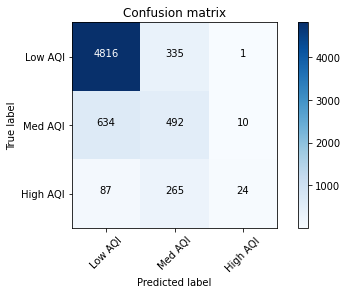

Day  36 :
MAE :  7.1833813126061425, RMSE :  10.23175792424048
High level RMSE: 27.374
High level MAE: 25.178
High level MAPE: 37.998
Med level RMSE: 12.310
Med level MAE: 10.387
Med level MAPE: 23.289
low level RMSE: 6.836
low level MAE: 5.149
low level MAPE: 28.224

              precision    recall  f1-score   support

     Low AQI       0.87      0.94      0.90      5152
  Medium AQI       0.47      0.42      0.44      1136
    High AQI       0.66      0.07      0.12       376

    accuracy                           0.80      6664
   macro avg       0.66      0.48      0.49      6664
weighted avg       0.79      0.80      0.78      6664




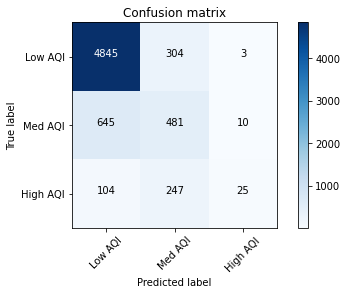

Day  37 :
MAE :  7.25533771726693, RMSE :  10.33421524542487
High level RMSE: 27.696
High level MAE: 25.510
High level MAPE: 38.547
Med level RMSE: 12.622
Med level MAE: 10.751
Med level MAPE: 24.116
low level RMSE: 6.815
low level MAE: 5.138
low level MAPE: 28.244

              precision    recall  f1-score   support

     Low AQI       0.86      0.94      0.90      5152
  Medium AQI       0.47      0.40      0.43      1136
    High AQI       0.57      0.07      0.12       376

    accuracy                           0.80      6664
   macro avg       0.63      0.47      0.49      6664
weighted avg       0.78      0.80      0.78      6664




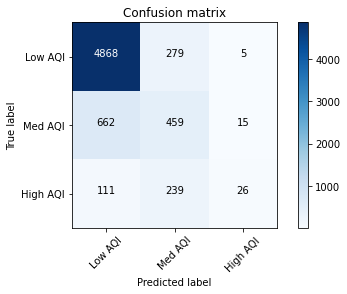

Day  38 :
MAE :  7.19368631152832, RMSE :  10.184509061598868
High level RMSE: 26.953
High level MAE: 24.662
High level MAPE: 37.213
Med level RMSE: 12.029
Med level MAE: 10.079
Med level MAPE: 22.585
low level RMSE: 6.977
low level MAE: 5.269
low level MAPE: 29.108

              precision    recall  f1-score   support

     Low AQI       0.87      0.93      0.90      5152
  Medium AQI       0.46      0.45      0.45      1136
    High AQI       0.59      0.08      0.14       376

    accuracy                           0.80      6664
   macro avg       0.64      0.49      0.50      6664
weighted avg       0.79      0.80      0.78      6664




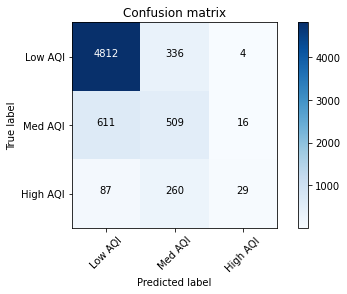

Day  39 :
MAE :  7.1923040538274945, RMSE :  10.19233930797884
High level RMSE: 27.012
High level MAE: 24.822
High level MAPE: 37.445
Med level RMSE: 11.958
Med level MAE: 9.900
Med level MAPE: 22.173
low level RMSE: 7.002
low level MAE: 5.294
low level MAPE: 28.975

              precision    recall  f1-score   support

     Low AQI       0.88      0.93      0.90      5152
  Medium AQI       0.46      0.48      0.47      1136
    High AQI       0.70      0.06      0.11       376

    accuracy                           0.80      6664
   macro avg       0.68      0.49      0.50      6664
weighted avg       0.80      0.80      0.78      6664




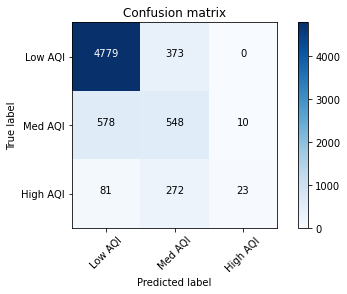

Day  40 :
MAE :  7.218639900904744, RMSE :  10.178736840487943
High level RMSE: 26.373
High level MAE: 24.117
High level MAPE: 36.358
Med level RMSE: 11.770
Med level MAE: 9.686
Med level MAPE: 21.722
low level RMSE: 7.222
low level MAE: 5.427
low level MAPE: 29.692

              precision    recall  f1-score   support

     Low AQI       0.88      0.92      0.90      5152
  Medium AQI       0.46      0.51      0.48      1136
    High AQI       0.61      0.06      0.11       376

    accuracy                           0.80      6664
   macro avg       0.65      0.50      0.50      6664
weighted avg       0.80      0.80      0.79      6664




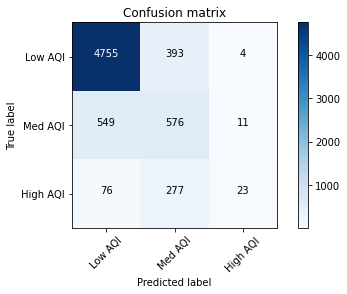

Day  41 :
MAE :  7.242212237086759, RMSE :  10.288906632029066
High level RMSE: 27.508
High level MAE: 25.407
High level MAPE: 38.339
Med level RMSE: 12.240
Med level MAE: 10.147
Med level MAPE: 22.680
low level RMSE: 6.934
low level MAE: 5.261
low level MAPE: 28.933

              precision    recall  f1-score   support

     Low AQI       0.87      0.93      0.90      5152
  Medium AQI       0.46      0.45      0.46      1136
    High AQI       0.67      0.04      0.07       376

    accuracy                           0.80      6664
   macro avg       0.67      0.48      0.48      6664
weighted avg       0.79      0.80      0.78      6664




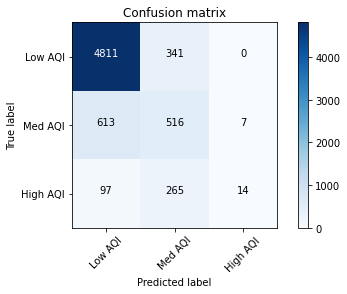

Day  42 :
MAE :  7.221457742585712, RMSE :  10.207970211261374
High level RMSE: 27.009
High level MAE: 24.892
High level MAPE: 37.561
Med level RMSE: 12.016
Med level MAE: 9.965
Med level MAPE: 22.310
low level RMSE: 7.010
low level MAE: 5.312
low level MAPE: 29.188

              precision    recall  f1-score   support

     Low AQI       0.88      0.93      0.90      5152
  Medium AQI       0.46      0.48      0.47      1136
    High AQI       0.62      0.05      0.09       376

    accuracy                           0.80      6664
   macro avg       0.65      0.49      0.49      6664
weighted avg       0.79      0.80      0.78      6664




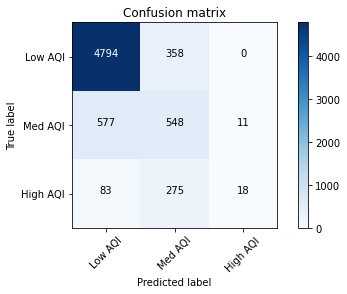

Day  43 :
MAE :  7.238587054055707, RMSE :  10.202275858221858
High level RMSE: 26.605
High level MAE: 24.448
High level MAPE: 36.890
Med level RMSE: 11.966
Med level MAE: 9.902
Med level MAPE: 22.198
low level RMSE: 7.131
low level MAE: 5.381
low level MAPE: 29.556

              precision    recall  f1-score   support

     Low AQI       0.88      0.93      0.90      5152
  Medium AQI       0.46      0.50      0.48      1136
    High AQI       0.54      0.04      0.07       376

    accuracy                           0.80      6664
   macro avg       0.63      0.49      0.49      6664
weighted avg       0.79      0.80      0.79      6664




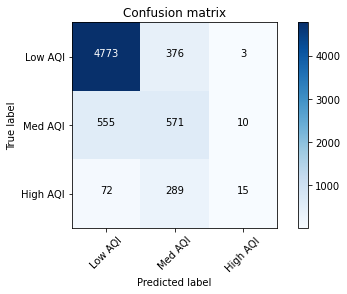

Day  44 :
MAE :  7.245719863701554, RMSE :  10.280435631512177
High level RMSE: 27.100
High level MAE: 24.859
High level MAPE: 37.509
Med level RMSE: 12.159
Med level MAE: 10.025
Med level MAPE: 22.432
low level RMSE: 7.067
low level MAE: 5.333
low level MAPE: 29.210

              precision    recall  f1-score   support

     Low AQI       0.88      0.93      0.90      5152
  Medium AQI       0.47      0.48      0.47      1136
    High AQI       0.48      0.04      0.08       376

    accuracy                           0.80      6664
   macro avg       0.61      0.48      0.48      6664
weighted avg       0.78      0.80      0.78      6664




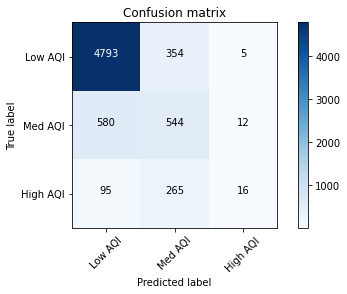

Day  45 :
MAE :  7.25738637547533, RMSE :  10.301940792413005
High level RMSE: 27.273
High level MAE: 25.110
High level MAPE: 37.905
Med level RMSE: 12.283
Med level MAE: 10.181
Med level MAPE: 22.764
low level RMSE: 7.012
low level MAE: 5.296
low level MAPE: 29.024

              precision    recall  f1-score   support

     Low AQI       0.87      0.93      0.90      5153
  Medium AQI       0.46      0.46      0.46      1135
    High AQI       0.50      0.03      0.06       376

    accuracy                           0.80      6664
   macro avg       0.61      0.47      0.47      6664
weighted avg       0.78      0.80      0.78      6664




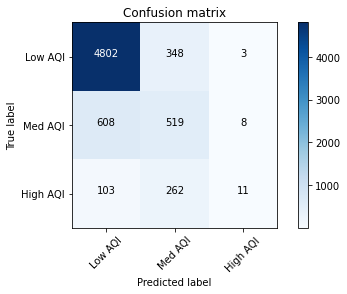

Day  46 :
MAE :  7.315890772145194, RMSE :  10.309238460058724
High level RMSE: 26.216
High level MAE: 23.894
High level MAPE: 36.049
Med level RMSE: 11.954
Med level MAE: 9.771
Med level MAPE: 21.894
low level RMSE: 7.437
low level MAE: 5.553
low level MAPE: 30.084

              precision    recall  f1-score   support

     Low AQI       0.88      0.92      0.90      5154
  Medium AQI       0.47      0.50      0.48      1134
    High AQI       0.34      0.04      0.07       376

    accuracy                           0.80      6664
   macro avg       0.56      0.49      0.48      6664
weighted avg       0.78      0.80      0.78      6664




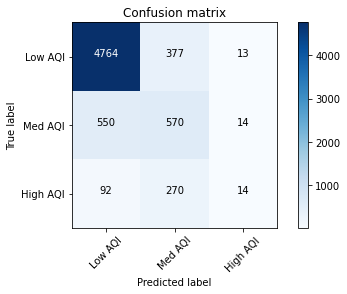


              precision    recall  f1-score   support

     Low AQI       0.87      0.93      0.90      5154
  Medium AQI       0.46      0.46      0.46      1134
    High AQI       0.41      0.05      0.09       376

    accuracy                           0.80      6664
   macro avg       0.58      0.48      0.48      6664
weighted avg       0.78      0.80      0.78      6664




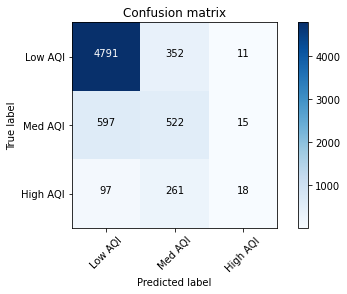

Day  47 :
MAE :  7.382969793151407, RMSE :  10.37684316958403
High level RMSE: 26.565
High level MAE: 24.234
High level MAPE: 36.597
Med level RMSE: 12.195
Med level MAE: 10.125
Med level MAPE: 22.676
low level RMSE: 7.381
low level MAE: 5.537
low level MAPE: 30.299

              precision    recall  f1-score   support

     Low AQI       0.87      0.93      0.90      5154
  Medium AQI       0.46      0.46      0.46      1134
    High AQI       0.41      0.05      0.09       376

    accuracy                           0.80      6664
   macro avg       0.58      0.48      0.48      6664
weighted avg       0.78      0.80      0.78      6664




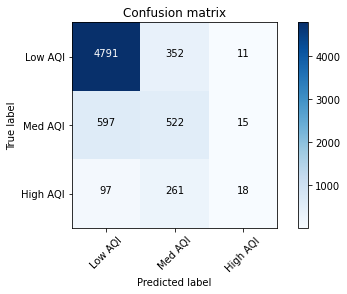

Day  48 :
MAE :  7.456164772656499, RMSE :  10.405758129599384
High level RMSE: 25.579
High level MAE: 23.126
High level MAPE: 34.866
Med level RMSE: 11.661
Med level MAE: 9.497
Med level MAPE: 21.302
low level RMSE: 7.864
low level MAE: 5.851
low level MAPE: 31.672

              precision    recall  f1-score   support

     Low AQI       0.89      0.91      0.90      5154
  Medium AQI       0.46      0.54      0.49      1134
    High AQI       0.41      0.06      0.11       376

    accuracy                           0.80      6664
   macro avg       0.59      0.50      0.50      6664
weighted avg       0.79      0.80      0.78      6664




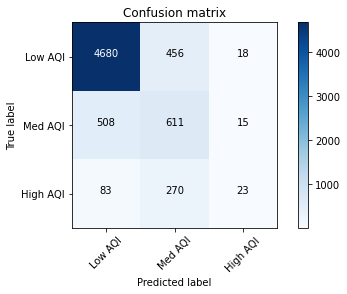

Day  49 :
MAE :  7.489897586975922, RMSE :  10.473006535786789
High level RMSE: 26.652
High level MAE: 24.456
High level MAPE: 36.946
Med level RMSE: 12.023
Med level MAE: 9.923
Med level MAPE: 22.180
low level RMSE: 7.592
low level MAE: 5.703
low level MAPE: 31.181

              precision    recall  f1-score   support

     Low AQI       0.88      0.92      0.90      5154
  Medium AQI       0.45      0.48      0.46      1134
    High AQI       0.21      0.01      0.02       376

    accuracy                           0.80      6664
   macro avg       0.51      0.47      0.46      6664
weighted avg       0.77      0.80      0.78      6664




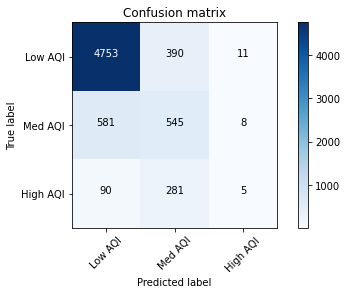

Day  50 :
MAE :  7.60743901563578, RMSE :  10.631645535444072
High level RMSE: 26.731
High level MAE: 24.383
High level MAPE: 36.797
Med level RMSE: 11.906
Med level MAE: 9.732
Med level MAPE: 21.726
low level RMSE: 7.891
low level MAE: 5.902
low level MAPE: 32.051

              precision    recall  f1-score   support

     Low AQI       0.88      0.91      0.89      5154
  Medium AQI       0.44      0.50      0.47      1134
    High AQI       0.41      0.04      0.07       376

    accuracy                           0.79      6664
   macro avg       0.58      0.48      0.48      6664
weighted avg       0.78      0.79      0.78      6664




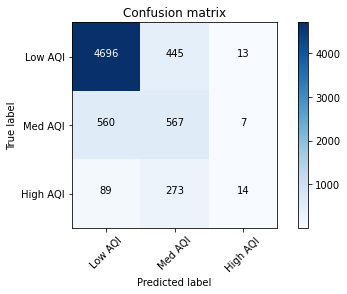

Day  51 :
MAE :  7.6973776952988535, RMSE :  10.754023980935317
High level RMSE: 27.367
High level MAE: 25.169
High level MAPE: 38.028
Med level RMSE: 12.132
Med level MAE: 9.966
Med level MAPE: 22.216
low level RMSE: 7.869
low level MAE: 5.909
low level MAPE: 31.943

              precision    recall  f1-score   support

     Low AQI       0.87      0.91      0.89      5154
  Medium AQI       0.43      0.47      0.45      1134
    High AQI       0.19      0.01      0.02       376

    accuracy                           0.79      6664
   macro avg       0.50      0.47      0.45      6664
weighted avg       0.76      0.79      0.77      6664




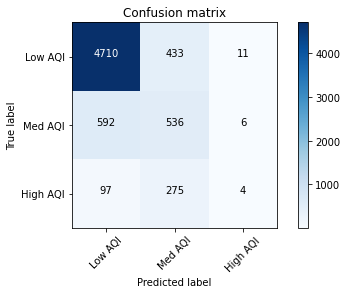

Day  52 :
MAE :  7.733723653779596, RMSE :  10.821371032768148
High level RMSE: 27.906
High level MAE: 25.776
High level MAPE: 38.959
Med level RMSE: 12.317
Med level MAE: 10.161
Med level MAPE: 22.632
low level RMSE: 7.785
low level MAE: 5.868
low level MAPE: 31.786

              precision    recall  f1-score   support

     Low AQI       0.87      0.92      0.89      5154
  Medium AQI       0.42      0.45      0.44      1134
    High AQI       0.12      0.01      0.01       376

    accuracy                           0.79      6664
   macro avg       0.47      0.46      0.45      6664
weighted avg       0.75      0.79      0.76      6664




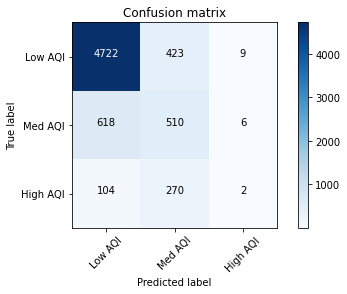

Day  53 :
MAE :  7.760658771679753, RMSE :  10.853156368083411
High level RMSE: 27.780
High level MAE: 25.649
High level MAPE: 38.802
Med level RMSE: 12.353
Med level MAE: 10.218
Med level MAPE: 22.772
low level RMSE: 7.863
low level MAE: 5.900
low level MAPE: 31.976

              precision    recall  f1-score   support

     Low AQI       0.86      0.92      0.89      5154
  Medium AQI       0.42      0.44      0.43      1134
    High AQI       0.23      0.02      0.03       376

    accuracy                           0.78      6664
   macro avg       0.51      0.46      0.45      6664
weighted avg       0.75      0.78      0.76      6664




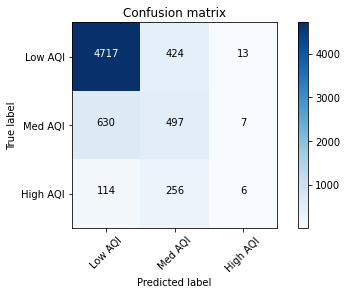

Day  54 :
MAE :  7.775239122414789, RMSE :  10.912921426333611
High level RMSE: 28.848
High level MAE: 26.894
High level MAPE: 40.662
Med level RMSE: 12.556
Med level MAE: 10.461
Med level MAPE: 23.251
low level RMSE: 7.611
low level MAE: 5.774
low level MAPE: 31.357

              precision    recall  f1-score   support

     Low AQI       0.86      0.92      0.89      5154
  Medium AQI       0.41      0.41      0.41      1134
    High AQI       0.25      0.01      0.01       376

    accuracy                           0.78      6664
   macro avg       0.51      0.44      0.44      6664
weighted avg       0.75      0.78      0.76      6664




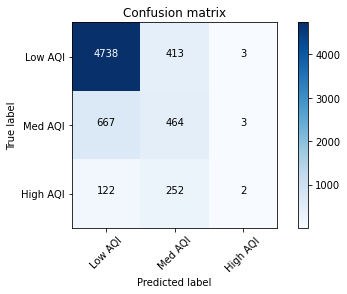

Day  55 :
MAE :  7.816530281040563, RMSE :  11.031389855318054
High level RMSE: 29.165
High level MAE: 26.994
High level MAPE: 40.848
Med level RMSE: 13.029
Med level MAE: 10.941
Med level MAPE: 24.356
low level RMSE: 7.568
low level MAE: 5.715
low level MAPE: 30.995

              precision    recall  f1-score   support

     Low AQI       0.85      0.92      0.89      5154
  Medium AQI       0.42      0.38      0.40      1134
    High AQI       0.42      0.03      0.05       376

    accuracy                           0.78      6664
   macro avg       0.56      0.44      0.45      6664
weighted avg       0.75      0.78      0.76      6664




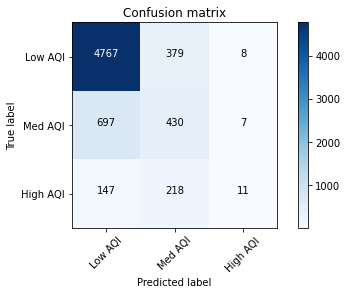

Day  56 :
MAE :  7.759336842494566, RMSE :  10.949667996151236
High level RMSE: 29.566
High level MAE: 27.669
High level MAPE: 41.855
Med level RMSE: 12.868
Med level MAE: 10.705
Med level MAPE: 23.772
low level RMSE: 7.357
low level MAE: 5.642
low level MAPE: 30.745

              precision    recall  f1-score   support

     Low AQI       0.85      0.92      0.88      5154
  Medium AQI       0.41      0.40      0.41      1134
    High AQI       1.00      0.01      0.01       376

    accuracy                           0.78      6664
   macro avg       0.76      0.44      0.43      6664
weighted avg       0.79      0.78      0.75      6664




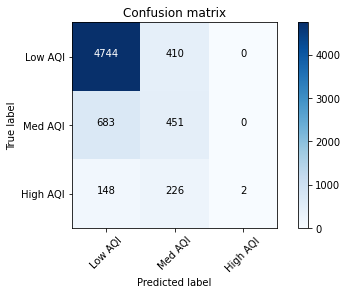

Day  57 :
MAE :  7.762534689359447, RMSE :  10.944961490658866
High level RMSE: 29.759
High level MAE: 28.006
High level MAPE: 42.389
Med level RMSE: 12.983
Med level MAE: 10.886
Med level MAPE: 24.165
low level RMSE: 7.246
low level MAE: 5.582
low level MAPE: 30.635

              precision    recall  f1-score   support

     Low AQI       0.85      0.93      0.89      5154
  Medium AQI       0.42      0.39      0.41      1134
    High AQI       0.00      0.00      0.00       376

    accuracy                           0.78      6664
   macro avg       0.42      0.44      0.43      6664
weighted avg       0.73      0.78      0.75      6664




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


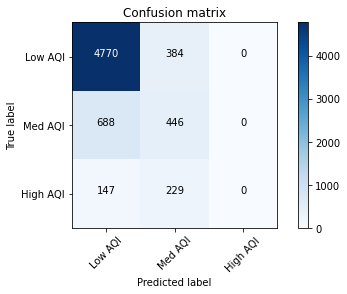

Day  58 :
MAE :  7.8286795164499825, RMSE :  11.033468303430977
High level RMSE: 29.453
High level MAE: 27.543
High level MAPE: 41.732
Med level RMSE: 13.201
Med level MAE: 11.138
Med level MAPE: 24.761
low level RMSE: 7.423
low level MAE: 5.646
low level MAPE: 30.882

              precision    recall  f1-score   support

     Low AQI       0.85      0.93      0.89      5154
  Medium AQI       0.43      0.37      0.40      1134
    High AQI       0.25      0.01      0.03       376

    accuracy                           0.78      6664
   macro avg       0.51      0.44      0.44      6664
weighted avg       0.74      0.78      0.75      6664




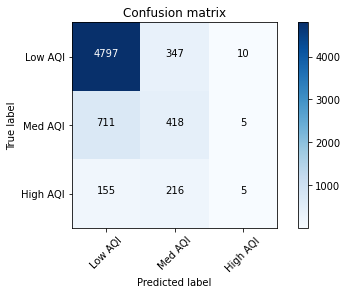

Day  59 :
MAE :  7.791167991959891, RMSE :  11.020728090410339
High level RMSE: 29.260
High level MAE: 27.138
High level MAPE: 41.082
Med level RMSE: 13.073
Med level MAE: 10.988
Med level MAPE: 24.430
low level RMSE: 7.504
low level MAE: 5.661
low level MAPE: 30.868

              precision    recall  f1-score   support

     Low AQI       0.85      0.93      0.89      5154
  Medium AQI       0.44      0.39      0.41      1134
    High AQI       0.51      0.05      0.09       376

    accuracy                           0.79      6664
   macro avg       0.60      0.45      0.46      6664
weighted avg       0.76      0.79      0.76      6664




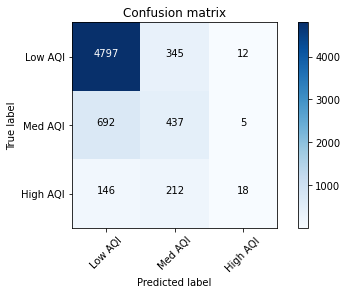

Day  60 :
MAE :  7.812265264286715, RMSE :  11.01365076152035
High level RMSE: 29.133
High level MAE: 26.968
High level MAPE: 40.856
Med level RMSE: 13.047
Med level MAE: 11.020
Med level MAPE: 24.524
low level RMSE: 7.539
low level MAE: 5.695
low level MAPE: 31.350

              precision    recall  f1-score   support

     Low AQI       0.85      0.93      0.89      5155
  Medium AQI       0.45      0.39      0.41      1133
    High AQI       0.45      0.06      0.10       376

    accuracy                           0.79      6664
   macro avg       0.58      0.46      0.47      6664
weighted avg       0.76      0.79      0.76      6664




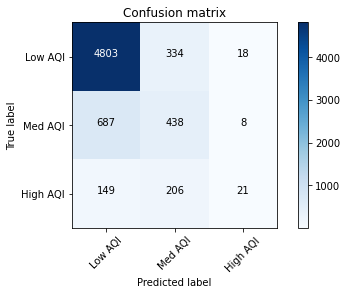

Day  61 :
MAE :  7.785614280483158, RMSE :  10.968919818701787
High level RMSE: 29.165
High level MAE: 26.975
High level MAPE: 40.799
Med level RMSE: 12.714
Med level MAE: 10.653
Med level MAPE: 23.666
low level RMSE: 7.571
low level MAE: 5.741
low level MAPE: 31.410

              precision    recall  f1-score   support

     Low AQI       0.86      0.93      0.89      5156
  Medium AQI       0.44      0.41      0.42      1132
    High AQI       0.54      0.05      0.09       376

    accuracy                           0.79      6664
   macro avg       0.61      0.46      0.47      6664
weighted avg       0.77      0.79      0.77      6664




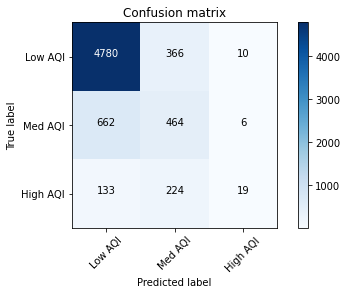

Day  62 :
MAE :  7.7804854739900104, RMSE :  10.962679426233876
High level RMSE: 29.412
High level MAE: 27.404
High level MAPE: 41.517
Med level RMSE: 12.956
Med level MAE: 10.897
Med level MAPE: 24.204
low level RMSE: 7.398
low level MAE: 5.650
low level MAPE: 31.192

              precision    recall  f1-score   support

     Low AQI       0.86      0.93      0.89      5157
  Medium AQI       0.44      0.40      0.42      1131
    High AQI       0.57      0.03      0.07       376

    accuracy                           0.79      6664
   macro avg       0.62      0.46      0.46      6664
weighted avg       0.77      0.79      0.77      6664




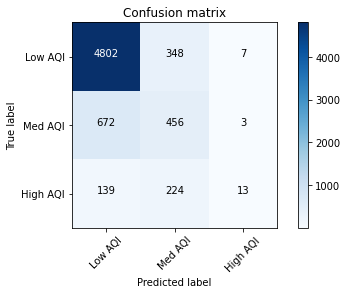

Day  63 :
MAE :  7.805728951937296, RMSE :  11.052585417635452
High level RMSE: 30.480
High level MAE: 28.624
High level MAPE: 43.319
Med level RMSE: 13.193
Med level MAE: 11.149
Med level MAPE: 24.680
low level RMSE: 7.158
low level MAE: 5.539
low level MAPE: 30.757

              precision    recall  f1-score   support

     Low AQI       0.85      0.94      0.89      5158
  Medium AQI       0.43      0.37      0.39      1130
    High AQI       0.00      0.00      0.00       376

    accuracy                           0.79      6664
   macro avg       0.42      0.43      0.43      6664
weighted avg       0.73      0.79      0.76      6664




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


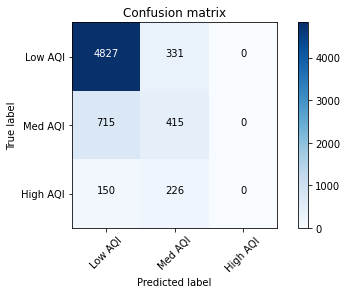

Day  64 :
MAE :  7.777438467605059, RMSE :  10.947814427591926
High level RMSE: 29.680
High level MAE: 27.762
High level MAPE: 41.994
Med level RMSE: 12.639
Med level MAE: 10.470
Med level MAPE: 23.154
low level RMSE: 7.414
low level MAE: 5.715
low level MAPE: 31.638

              precision    recall  f1-score   support

     Low AQI       0.86      0.92      0.89      5159
  Medium AQI       0.42      0.42      0.42      1129
    High AQI       0.00      0.00      0.00       376

    accuracy                           0.78      6664
   macro avg       0.43      0.45      0.44      6664
weighted avg       0.74      0.78      0.76      6664




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


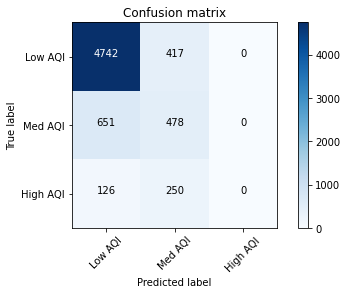

Day  65 :
MAE :  7.752730206481549, RMSE :  11.004002007109461
High level RMSE: 30.146
High level MAE: 28.183
High level MAPE: 42.650
Med level RMSE: 13.063
Med level MAE: 10.928
Med level MAPE: 24.191
low level RMSE: 7.221
low level MAE: 5.553
low level MAPE: 30.845

              precision    recall  f1-score   support

     Low AQI       0.85      0.93      0.89      5160
  Medium AQI       0.42      0.39      0.40      1128
    High AQI       0.00      0.00      0.00       376

    accuracy                           0.79      6664
   macro avg       0.43      0.44      0.43      6664
weighted avg       0.73      0.79      0.76      6664




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


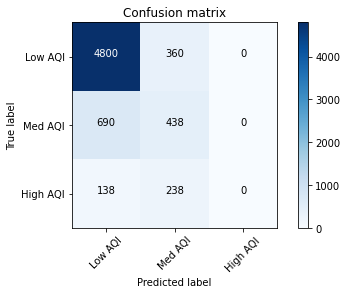

Day  66 :
MAE :  7.787474705391571, RMSE :  10.94034438070636
High level RMSE: 29.535
High level MAE: 27.611
High level MAPE: 41.757
Med level RMSE: 12.533
Med level MAE: 10.331
Med level MAPE: 22.843
low level RMSE: 7.484
low level MAE: 5.771
low level MAPE: 32.224

              precision    recall  f1-score   support

     Low AQI       0.86      0.92      0.89      5161
  Medium AQI       0.42      0.44      0.43      1127
    High AQI       0.00      0.00      0.00       376

    accuracy                           0.78      6664
   macro avg       0.43      0.45      0.44      6664
weighted avg       0.74      0.78      0.76      6664




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


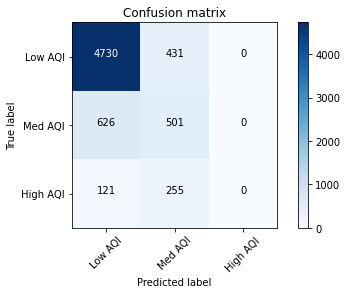

Day  67 :
MAE :  7.7731929783059766, RMSE :  11.06324876645512
High level RMSE: 30.148
High level MAE: 28.115
High level MAPE: 42.560
Med level RMSE: 13.240
Med level MAE: 11.083
Med level MAPE: 24.547
low level RMSE: 7.270
low level MAE: 5.553
low level MAPE: 30.836

              precision    recall  f1-score   support

     Low AQI       0.85      0.93      0.89      5162
  Medium AQI       0.41      0.36      0.38      1126
    High AQI       0.50      0.01      0.03       376

    accuracy                           0.78      6664
   macro avg       0.59      0.43      0.43      6664
weighted avg       0.75      0.78      0.75      6664




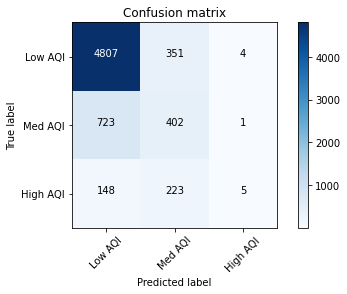

Day  68 :
MAE :  7.784333457380068, RMSE :  11.02697830484718
High level RMSE: 29.710
High level MAE: 27.807
High level MAPE: 42.125
Med level RMSE: 13.039
Med level MAE: 10.850
Med level MAPE: 24.036
low level RMSE: 7.411
low level MAE: 5.642
low level MAPE: 31.243

              precision    recall  f1-score   support

     Low AQI       0.85      0.92      0.89      5163
  Medium AQI       0.41      0.39      0.40      1125
    High AQI       0.00      0.00      0.00       376

    accuracy                           0.78      6664
   macro avg       0.42      0.44      0.43      6664
weighted avg       0.73      0.78      0.75      6664




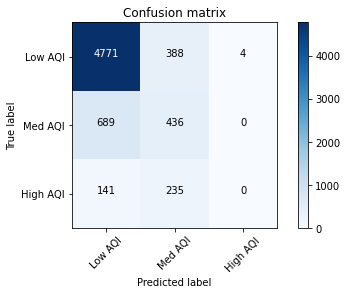

Day  69 :
MAE :  7.789261672705734, RMSE :  11.071691026936337
High level RMSE: 29.699
High level MAE: 27.530
High level MAPE: 41.689
Med level RMSE: 13.212
Med level MAE: 11.055
Med level MAPE: 24.509
low level RMSE: 7.436
low level MAE: 5.625
low level MAPE: 31.143

              precision    recall  f1-score   support

     Low AQI       0.85      0.92      0.88      5164
  Medium AQI       0.40      0.36      0.38      1124
    High AQI       0.45      0.03      0.06       376

    accuracy                           0.78      6664
   macro avg       0.57      0.44      0.44      6664
weighted avg       0.75      0.78      0.75      6664




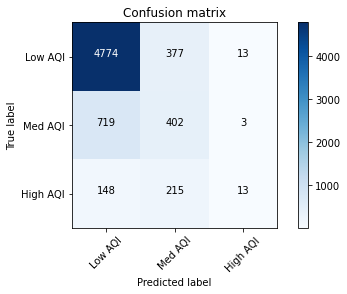

Day  70 :
MAE :  7.802816868314939, RMSE :  11.053038271796611
High level RMSE: 29.604
High level MAE: 27.526
High level MAPE: 41.673
Med level RMSE: 12.957
Med level MAE: 10.771
Med level MAPE: 23.858
low level RMSE: 7.526
low level MAE: 5.705
low level MAPE: 31.429

              precision    recall  f1-score   support

     Low AQI       0.85      0.92      0.89      5165
  Medium AQI       0.40      0.38      0.39      1123
    High AQI       0.20      0.01      0.02       376

    accuracy                           0.78      6664
   macro avg       0.48      0.44      0.43      6664
weighted avg       0.74      0.78      0.75      6664




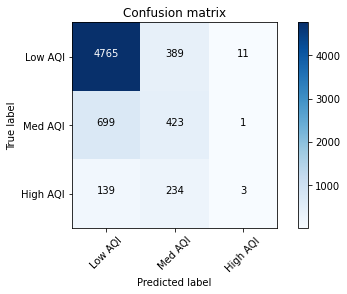


              precision    recall  f1-score   support

     Low AQI       0.85      0.93      0.89      5166
  Medium AQI       0.41      0.35      0.38      1122
    High AQI       0.21      0.01      0.02       376

    accuracy                           0.78      6664
   macro avg       0.49      0.43      0.43      6664
weighted avg       0.74      0.78      0.75      6664




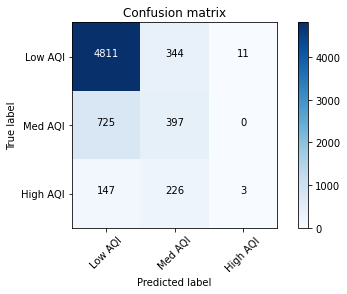

Day  71 :
MAE :  7.809034081066355, RMSE :  11.119705908127932
High level RMSE: 30.036
High level MAE: 28.003
High level MAPE: 42.441
Med level RMSE: 13.351
Med level MAE: 11.177
Med level MAPE: 24.779
low level RMSE: 7.377
low level MAE: 5.591
low level MAPE: 30.768

              precision    recall  f1-score   support

     Low AQI       0.85      0.93      0.89      5166
  Medium AQI       0.41      0.35      0.38      1122
    High AQI       0.21      0.01      0.02       376

    accuracy                           0.78      6664
   macro avg       0.49      0.43      0.43      6664
weighted avg       0.74      0.78      0.75      6664




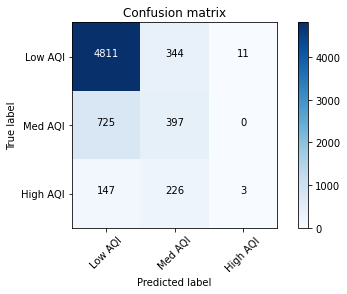

[2.961991193229078, 0.9498799519807923, 0.8986858833423668, 7.798640096918132, 0.8415366146458584, 0.6506337529219463, 8.52418426661407, 0.8221788715486195, 0.5535005900612713, 8.82495740692821, 0.8251800720288115, 0.5592918133375443, 10.37684316958403, 0.799969987995198, 0.4821591436112355, 11.119705908127932, 0.7819627851140456, 0.42745759987777693]


In [87]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error , mean_absolute_error
import math

result = []
for j in range(0,72):
  if j == 0 or j == 5 or j== 11 or j == 23 or j == 47 or j==71:
    score = math.sqrt(mean_squared_error(y_test[:,j],pred[:,j]))
    result.append(score)
    cls_report = generate_class(y_test.reshape(y_test.shape[0],y_test.shape[1],1),pred.reshape(pred.shape[0],pred.shape[1],1),j)
    f1_acc = cls_report['accuracy']
    macro = cls_report['macro avg']
    macro_f1 = macro['f1-score']
    result.append(f1_acc)
    result.append(macro_f1)
  print("Day ",j,":")
  print("MAE : ",mean_absolute_error(y_test[:,j],pred[:,j]),end=", ")
  print("RMSE : ",math.sqrt(mean_squared_error(y_test[:,j],pred[:,j])))
  evaluate_level(y_test.reshape(y_test.shape[0],y_test.shape[1],1),pred.reshape(pred.shape[0],pred.shape[1],1),j)
  generate_class(y_test.reshape(y_test.shape[0],y_test.shape[1],1),pred.reshape(pred.shape[0],pred.shape[1],1),j)
  print("====================================================")
print(result)

In [88]:
result_df = pd.DataFrame(data=[result],index=['GRU Bangkok'],columns=['RMSE t+1','f1 acc t+1','macro avg t+1','RMSE t+6','f1 acc t+6','macro avg t+6','RMSE t+12','f1 acc t+12','macro avg t+12','RMSE t+24','f1 acc t+24','macro avg t+24','RMSE t+48','f1 acc t+48','macro avg t+48','RMSE t+72','f1 acc t+72','macro avg t+72',])
result_df

,RMSE t+1,f1 acc t+1,macro avg t+1,RMSE t+6,f1 acc t+6,macro avg t+6,RMSE t+12,f1 acc t+12,macro avg t+12,RMSE t+24,f1 acc t+24,macro avg t+24,RMSE t+48,f1 acc t+48,macro avg t+48,RMSE t+72,f1 acc t+72,macro avg t+72
GRU Bangkok,2.961991,0.94988,0.898686,7.79864,0.841537,0.650634,8.524184,0.822179,0.553501,8.824957,0.82518,0.559292,10.376843,0.79997,0.482159,11.119706,0.781963,0.427458


In [92]:
result_df.to_csv('results/GRU Bangkok.csv')

In [94]:
import json
province = 'Bangkok'
path = 'model_weights'
gru.save(f'''{path}/{province}''')

model_config = {
    'ft_cols' : ft_cols,
    'opt_name' : 'Adam',
    'batch_size' : 128,
    'learning rate' : 0.0001,
    'province': province,
    'lag' : 24,
    'n_neurons' : 128,
    'n_ft' : 6,
    'forecast' : 72,
}

config_path = 'config'
config_name = f'{config_path}/{province}_config.json'
with open(config_name, 'w') as json_file :
    json.dump(model_config, json_file)

INFO:tensorflow:Assets written to: model_weights/Bangkok/assets


INFO:tensorflow:Assets written to: model_weights/Bangkok/assets
